In [101]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

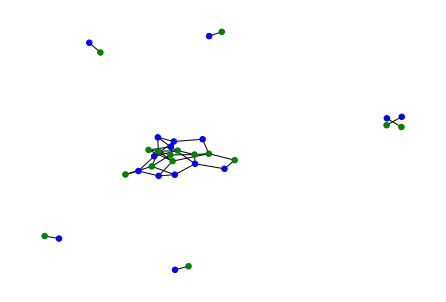

In [109]:
fig_idx = 0
def new_fig():
    global fig_idx
    plt.figure(fig_idx)
    fig_idx += 1

def sort_degree_centrality_desc(G):
    degree_centrality = dict(nx.degree_centrality(G))
    return {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

def draw_interdependent_G(G):
    global ATTR_LAYER, LAYER_A_TAG, LAYER_B_TAG
    layer_attr=nx.get_node_attributes(G,ATTR_LAYER)
    color_map = ['b' if layer_attr[node][0]== LAYER_A_TAG else 'g' for node in list(G.nodes())]
    new_fig()
    nx.draw(G, node_color=color_map, node_size=30)
### Singe Random Network
### network config
AVG_DEGREE = 4
NUM_NODE = 20
ATTACK_NODE_NUM = 1
M_MONTE_CARLO = 100

ATTR_LAYER = "layer"
LAYER_A_TAG = "L_A"
LAYER_B_TAG = "L_B"
###
### with certain average degree
##### ER
def generate_ER(avg_degree):
    p = np.true_divide(avg_degree, NUM_NODE)
    return nx.erdos_renyi_graph(NUM_NODE, p)
#### WS
def generate_WS(avg_degree):
    pass
#### BA
def generate_BA(avg_degree):
    pass

### inter-connect
### add properties of whether nodes is Layer A or B for further use
### return: G
####
#### e.g. max_max means nodes in layer A with highest degree centralities
####         connect to  nodes in layer A with highest degree centralities
def interconnect_random(G_layer_A, G_layer_B):
    pass
def interconnect_by_degree_centralities(G_layer_A, L_A_degree_c, G_layer_B, L_B_degree_c ):
    G = nx.union(G_layer_A, G_layer_B)
    layer_mapping = dict()
    for idx in range(len(L_A_degree_c.items())):
        node_A = list(L_A_degree_c.keys())[idx]
        node_B = list(L_B_degree_c.keys())[idx]
        layer_mapping.update(dict({node_A:node_B}))
        G.add_edge(node_A, node_B)
    return G, layer_mapping
def interconnect_max_max_degree_centralities(G_layer_A, G_layer_B):
    global LAYER_A_TAG, LAYER_B_TAG
    L_A_degree_c = sort_degree_centrality_desc(G_layer_A)
    L_B_degree_c = sort_degree_centrality_desc(G_layer_B)
    return interconnect_by_degree_centralities(G_layer_A, L_A_degree_c, G_layer_B, L_B_degree_c)
def interconnect_max_min_degree_centralities(G_layer_A, G_layer_B):
    pass
def interconnect_min_max_degree_centralities(G_layer_A, G_layer_B):
    pass
def interconnect_min_min_degree_centralities(G_layer_A, G_layer_B):
    pass

def interconnect_max_max_connectness(G_layer_A, G_layer_B):
    pass
def interconnect_min_max_connectness(G_layer_A, G_layer_B):
    pass
def interconnect_max_min_connectness(G_layer_A, G_layer_B):
    pass
def interconnect_min_min_connectness(G_layer_A, G_layer_B):
    pass


def interconnect_max_max_betweeness(G_layer_A, G_layer_B):
    pass
def interconnect_max_min_betweeness(G_layer_A, G_layer_B):
    pass
def interconnect_min_max_betweeness(G_layer_A, G_layer_B):
    pass
def interconnect_min_min_betweeness(G_layer_A, G_layer_B):
    pass

#### simulation
def simulate(interdependent_G:nx.Graph, L_A:nx.Graph, L_B:nx.Graph, layer_mapping, attack_nodes:[]):
    global M_MONTE_CARLO, NODE_DESTROY_THRESHOLD, LAYER_A_TAG, LAYER_B_TAG
    G = interdependent_G.copy()

    ## reomove nodes in G
    G.remove_nodes_from(attack_nodes)
    ## remove nodes in A and B
    L_A.remove_nodes_from(attack_nodes)
    L_B.remove_nodes_from(attack_nodes)
    for node in attack_nodes:
        L_B.remove_node(layer_mapping[node])
        G.remove_node(layer_mapping[node])
    layer_mapping_B_to_A = {v: k for k, v in layer_mapping.items()}
    while True:
        L_A_ends=True
        L_B_ends = True
        ## find cluster in A
        clusters_A = list(nx.connected_components(L_A))
        ### for cluster A_i
        for c_A in clusters_A:
            c_A_to_B = [layer_mapping[n_A] for n_A in c_A]
            for n_B in c_A_to_B:
                edges =  L_B.edges(n_B)
                remove_edges = []
                for edge in edges:
                    if (edge[0] not in c_A_to_B) or (edge[1] not in c_A_to_B):
                        remove_edges.append(edge)
                if len(remove_edges)>0:
                    G.remove_edges_from(remove_edges)
                    L_B.remove_edges_from(remove_edges)
                    L_A_ends=False
        ## find cluster in B
        clusters_B = list(nx.connected_components(L_B))
        for c_B in clusters_B:
            c_B_to_A = [layer_mapping_B_to_A[n_B] for n_B in c_B]
            for n_A in c_B_to_A:
                edges =  L_A.edges(n_A)
                remove_edges = []
                for edge in edges:
                    if (edge[0] not in c_B_to_A) or (edge[1] not in c_B_to_A):
                        remove_edges.append(edge)
                if len(remove_edges)>0:
                    G.remove_edges_from(remove_edges)
                    L_A.remove_edges_from(remove_edges)
                    L_B_ends=False
        if (L_A_ends and L_B_ends) :
            break
    return measurement(G)


#### measurement
def measurement(G):
    ## measurement
    giant_component_exist = 1
    #### largest component size / G size
    miu = 0.0

    draw_interdependent_G(G)

    G_nodes_num = len(G.nodes())
    sub_components = sorted(nx.connected_components(G), key=len, reverse=True)
    G_0_size = len(sub_components[0])
    G_0 = G.subgraph(sub_components[0])
    if (G_nodes_num > G_0_size):
        giant_component_exist = 0

    miu = np.true_divide(G_0_size,G_nodes_num)

    ###
    ret = giant_component_exist, miu
    return ret


#### attack nodes
def attack_random_Layer_A(G_interdependent):
    global ATTACK_NODE_NUM

    return []
def attack_high_degree_centrality_Layer_A(G_A, P):
    global  LAYER_A_TAG
    degree_c = sort_degree_centrality_desc(G_A)
    num = round(P*len(G_A.nodes()))
    return  [t[0] for t in list(degree_c.items())[:num]]

def set_Layer_tag(G:nx.Graph, tag):
    G = nx.relabel_nodes(G, lambda i: tag+"_"+str(i))

    labels = [tag]
    global ATTR_LAYER
    nx.set_node_attributes(G, labels, ATTR_LAYER)
    return G
def draw_plot(measurement_ret):
    pass
##### experiment: Failure cascade
def experiment(layer_A_function, layer_B_function, interconnect_function, attack_strategy):
    global AVG_DEGREE
    num_iter = 100
    ret_p = []
    for p in np.arange(0.01, 1.01, 0.01):
        iter_ret=[]
        for i in range(num_iter):
            # Build interdependent networks
            ### construct Layer A
            G_A = layer_A_function(AVG_DEGREE)
            G_A = set_Layer_tag(G_A, LAYER_A_TAG)
            ### construct Layer B
            G_B = layer_B_function(AVG_DEGREE)
            G_B = set_Layer_tag(G_B, LAYER_B_TAG)

            ### interconnect
            G,layer_mapping = interconnect_function(G_A, G_B)

            # select nodes to attack
            attack_nodes = attack_strategy(G_A,p)

            # simulate cascade
            iter_ret.append(np.asarray(simulate(G, G_A, G_B, layer_mapping, attack_nodes)))
        ret_p.append(np.mean(iter_ret, axis=0))
    draw_plot(ret_p)


experiment(lambda avg_d:generate_ER(avg_d),lambda avg_d:generate_ER(avg_d),
           lambda G_A,G_B: interconnect_max_max_degree_centralities(G_A, G_B),
           lambda G,P: attack_high_degree_centrality_Layer_A(G, P))